In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from math import comb

In [16]:
# vc_growth_empirico.py
# ------------------------------------------------------------
# Empírico vs teórico para:
# (a) Umbrales en R
# (b) Intervalos en R
# (c) Separadores lineales en R^2
#
# Salidas:
#   - Tabla CSV: growth_values.csv
#   - Figuras PNG:
#       1) thresholds_growth.png
#       2) intervals_growth.png
#       3) linear2d_growth.png
#       4) all_growth_together.png
#
# Requisitos: Python 3.9+ (usa math.comb), numpy, matplotlib, pandas
# ------------------------------------------------------------

import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Iterable, List, Tuple, Sequence, Set

RNG = np.random.default_rng(42)

# -------------------------
# Utilidades generales
# -------------------------
def unique_labelings(label_sets: Iterable[Sequence[int]]) -> int:
    """Cuenta dicotomías distintas (tuplas 0/1 únicas)."""
    return len({tuple(labels) for labels in label_sets})

def general_position_noise(arr, scale=1e-6):
    return arr + scale * RNG.normal(size=arr.shape)

# -------------------------
# (a) Umbrales en R
# -------------------------
def thresholds_labelings_1d(xs: Sequence[float]) -> List[Tuple[int, ...]]:
    xs = np.asarray(xs, dtype=float)
    order = np.argsort(xs)
    n = len(xs)
    labelings = []
    # Umbral t entre xs[k] y xs[k+1]; incluimos t < min y t > max
    for k in range(-1, n):
        labels_sorted = np.zeros(n, dtype=int)
        if k < n - 1:
            labels_sorted[k+1:] = 1
        labels = np.zeros(n, dtype=int)
        labels[order] = labels_sorted
        labelings.append(tuple(labels.tolist()))
    return labelings

def can_separate_thresholds(xs: Sequence[float], y: Sequence[int]) -> bool:
    """Chequea si existe umbral que realice y (0/1) en xs (1D)."""
    xs = np.asarray(xs, dtype=float)
    y = np.asarray(y, dtype=int)
    order = np.argsort(xs)
    y_sorted = y[order]
    # Realizable si y_sorted es todo 0s, todo 1s o cambia de 0→1 una sola vez
    changes = np.diff(y_sorted)
    # no se permite 1→0 (retroceso)
    return np.all((changes >= 0))  # sólo 0->0, 0->1, 1->1

# -------------------------
# (b) Intervalos en R
# -------------------------
def intervals_labelings_1d(xs: Sequence[float]) -> List[Tuple[int, ...]]:
    xs = np.asarray(xs, dtype=float)
    order = np.argsort(xs)
    n = len(xs)
    labelings: Set[Tuple[int, ...]] = set()
    labelings.add(tuple([0]*n))  # intervalo vacío

    for i in range(n):
        for j in range(i, n):
            labels_sorted = np.zeros(n, dtype=int)
            labels_sorted[i:j+1] = 1
            labels = np.zeros(n, dtype=int)
            labels[order] = labels_sorted
            labelings.add(tuple(labels.tolist()))
    return list(labelings)

def can_separate_intervals(xs: Sequence[float], y: Sequence[int]) -> bool:
    """Chequea si y (0/1) es un bloque contiguo en el orden de xs."""
    xs = np.asarray(xs, dtype=float)
    y = np.asarray(y, dtype=int)
    order = np.argsort(xs)
    y_sorted = y[order]
    # patrón válido: 0...0 1...1 0...0 (a lo sumo un bloque de 1s)
    ones_idx = np.where(y_sorted == 1)[0]
    if len(ones_idx) == 0:
        return True
    return np.all(np.diff(ones_idx) == 1)

# -------------------------
# (c) Separadores lineales en R^2
# -------------------------
def halfspace_labelings_2d(points: Sequence[Sequence[float]], num_angles: int = 181) -> List[Tuple[int, ...]]:
    """Aproximación por proyecciones sobre ángulos muestreados en [0, pi)."""
    pts = np.asarray(points, dtype=float)
    n = len(pts)
    labelings: Set[Tuple[int, ...]] = set()
    for deg in np.linspace(0, 179, num_angles):
        theta = math.radians(deg)
        u = np.array([math.cos(theta), math.sin(theta)])  # normal
        proj = pts @ u
        order = np.argsort(proj)
        for k in range(-1, n):
            labels_sorted = np.zeros(n, dtype=int)
            if k < n - 1:
                labels_sorted[k+1:] = 1
            labels = np.zeros(n, dtype=int)
            labels[order] = labels_sorted
            labelings.add(tuple(labels.tolist()))
    return list(labelings)

def perceptron_separable(points: Sequence[Sequence[float]], y_pm1: Sequence[int], max_iter: int = 10_000) -> bool:
    """Chequea separabilidad lineal con sesgo usando Perceptrón (y en {-1,+1})."""
    X = np.asarray(points, dtype=float)
    y = np.asarray(y_pm1, dtype=float)
    n, d = X.shape
    # agregar término de sesgo
    Xb = np.hstack([X, np.ones((n, 1))])
    w = np.zeros(d+1)
    it = 0
    while it < max_iter:
        margins = y * (Xb @ w)
        mis = np.where(margins <= 0)[0]
        if mis.size == 0:
            return True
        i = mis[RNG.integers(0, mis.size)]
        w += y[i] * Xb[i]
        it += 1
    return False  # no convergió dentro de max_iter

def can_separate_linear2d(points: Sequence[Sequence[float]], y01: Sequence[int]) -> bool:
    """Chequea si existe separador lineal 2D que realice y (0/1)."""
    y_pm1 = np.where(np.asarray(y01) == 1, 1, -1)
    return perceptron_separable(points, y_pm1)

# -------------------------
# Curvas empíricas vs teóricas
# -------------------------
def empirical_growth_function(class_name: str, n_values: Sequence[int], trials: int = 30, angles: int = 181) -> np.ndarray:
    mhat = []
    for n in n_values:
        best = 0
        for _ in range(trials):
            if class_name == "thresholds":
                xs = general_position_noise(RNG.uniform(0, 1, size=n))
                labs = thresholds_labelings_1d(xs)
            elif class_name == "intervals":
                xs = general_position_noise(RNG.uniform(0, 1, size=n))
                labs = intervals_labelings_1d(xs)
            elif class_name == "halfspaces2d":
                pts = general_position_noise(RNG.uniform(0, 1, size=(n, 2)))
                labs = halfspace_labelings_2d(pts, num_angles=angles)
            else:
                raise ValueError("Clase desconocida")
            best = max(best, unique_labelings(labs))
        mhat.append(best)
    return np.array(mhat, dtype=int)

def theoretical_curves(n_vals: np.ndarray):
    thr = n_vals + 1
    inter = (n_vals * (n_vals + 1)) // 2 + 1
    lin2d = n_vals**2 - n_vals + 2
    return thr, inter, lin2d

# -------------------------
# Gráficas y exportes
# -------------------------
def plot_single(n_vals, emp, theo, title, outfile):
    plt.figure(figsize=(8,5))
    plt.plot(n_vals, emp, marker='o', label="Empírico")
    plt.plot(n_vals, theo, linestyle='--', marker='x', label="Teórico")
    plt.xlabel("n (número de puntos)")
    plt.ylabel("m_H(n) (# de dicotomías)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=160)
    plt.close()

def plot_all(n_vals, thr_emp, thr_theo, int_emp, int_theo, lin_emp, lin_theo, outfile):
    plt.figure(figsize=(10,6))
    plt.plot(n_vals, thr_emp, marker='o', label="Empírico - Umbrales")
    plt.plot(n_vals, thr_theo, linestyle='--', marker='x', label="Teórico - Umbrales")
    plt.plot(n_vals, int_emp, marker='o', label="Empírico - Intervalos")
    plt.plot(n_vals, int_theo, linestyle='--', marker='x', label="Teórico - Intervalos")
    plt.plot(n_vals, lin_emp, marker='o', label="Empírico - Lin. 2D")
    plt.plot(n_vals, lin_theo, linestyle='--', marker='x', label="Teórico - Lin. 2D")
    plt.xlabel("n (número de puntos)")
    plt.ylabel("m_H(n) (# de dicotomías)")
    plt.title("Funciones de crecimiento: empíricas vs teóricas")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=160)
    plt.close()

def main():
    # Rango de n
    n_vals = np.arange(1, 15, dtype=int)

    # Estimaciones empíricas
    thr_emp = empirical_growth_function("thresholds", n_vals, trials=25)
    int_emp = empirical_growth_function("intervals", n_vals, trials=25)
    lin_emp = empirical_growth_function("halfspaces2d", n_vals, trials=25, angles=181)

    # Curvas teóricas
    thr_theo, int_theo, lin_theo = theoretical_curves(n_vals)

    # Tabla CSV
    df = pd.DataFrame({
        "n": n_vals,
        "Emp_Umbrales": thr_emp,
        "Theo_Umbrales": thr_theo,
        "Emp_Intervalos": int_emp,
        "Theo_Intervalos": int_theo,
        "Emp_Lineal2D": lin_emp,
        "Theo_Lineal2D": lin_theo
    })
    df.to_csv("growth_values.csv", index=False)

    # Gráficas por separado
    plot_single(n_vals, thr_emp, thr_theo, "Umbrales en R: empírico vs teórico", "thresholds_growth.png")
    plot_single(n_vals, int_emp, int_theo, "Intervalos en R: empírico vs teórico", "intervals_growth.png")
    plot_single(n_vals, lin_emp, lin_theo, "Separadores lineales en R^2: empírico vs teórico", "linear2d_growth.png")

    # Gráfica combinada
    plot_all(n_vals, thr_emp, thr_theo, int_emp, int_theo, lin_emp, lin_theo, "all_growth_together.png")

    # Mensaje final en consola
    print("Listo. Archivos generados:")
    print(" - growth_values.csv")
    print(" - thresholds_growth.png")
    print(" - intervals_growth.png")
    print(" - linear2d_growth.png")
    print(" - all_growth_together.png")

if __name__ == "__main__":
    main()


Listo. Archivos generados:
 - growth_values.csv
 - thresholds_growth.png
 - intervals_growth.png
 - linear2d_growth.png
 - all_growth_together.png


# Inciso 1 : Estimación empírica de la Dimensión VC


1. Clases de hipótesis consideradas
- **Umbrales en ℝ**: clasificadores de la forma  $ h(x) = \mathbb{1}[x \geq t] $  
  
  - Dimensión VC: 1  
  - Función de crecimiento teórica: \( m+1 \).


In [4]:
def separable_umbral(X, y):
    X = np.array(X)
    y = np.array(y)
    
    thresholds = np.concatenate([
        [X.min() - 1],
        (X[:-1] + X[1:]) / 2,
        [X.max() + 1]
    ])
    
    for t in thresholds:
        pred1 = (X >= t).astype(int)
        pred2 = (X < t).astype(int)  # inverso
        if np.array_equal(pred1, y) or np.array_equal(pred2, y):
            return True
    return False

- **Intervalos en ℝ**: clasificadores de la forma $ h(x) = \mathbb{1}[a \leq x \leq b] $  

  - Dimensión VC: 2  
  - Función de crecimiento teórica:  
    $
    1 + \frac{m(m+1)}{2}
    $

In [5]:
def separable_intervalo(X, y):
    X = np.array(X)
    y = np.array(y)
    
    for i in range(len(X)):
        for j in range(i, len(X)):
            a, b = X[i], X[j]
            pred = ((X >= a) & (X <= b)).astype(int)
            pred_inv = 1 - pred
            if np.array_equal(pred, y) or np.array_equal(pred_inv, y):
                return True
    return False

- **Separadores lineales en ℝ²**:  
  $ h(x) = \mathbb{1}[w \cdot x + b \geq 0] $.  
  - Dimensión VC: 3  
  - Función de crecimiento teórica:  
    $1 + m + \binom{m}{2} + \binom{m}{3} $

In [6]:
def separable_lineal(X, y):
    # Caso trivial: todas las etiquetas iguales
    if len(set(y)) == 1:
        return True
    
    clf = Perceptron(max_iter=1000, tol=1e-3)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    return np.array_equal(y, y_pred)

In [7]:
def funcion_crecimiento(X, clase):
    m = len(X)
    realizables = set()
    for y_bits in itertools.product([0,1], repeat=m):
        y = np.array(y_bits)
        if clase(X, y):
            realizables.add(tuple(y))
    return len(realizables)

1. Se implementaron funciones que verifican si una clase de hipótesis puede separar un conjunto de puntos con un etiquetado dado.  
2. Para un conjunto de $ m $ puntos:  
   - Se enumeraron los $ 2^m $ posibles etiquetados.  
   - Se verificó si alguno podía realizarse con la clase de hipótesis.  
3. Se contó el número de etiquetados realizables y se comparó con la curva teórica.

In [8]:
max_m = 6

# Umbrales en R
gc_emp_umbral = []
gc_teo_umbral = []
for m in range(1, max_m+1):
    X = np.arange(m)  # puntos simples
    gc_emp_umbral.append(funcion_crecimiento(X, separable_umbral))
    gc_teo_umbral.append(m + 1)

# Intervalos en R
gc_emp_intervalo = []
gc_teo_intervalo = []
for m in range(1, max_m+1):
    X = np.arange(m)
    gc_emp_intervalo.append(funcion_crecimiento(X, separable_intervalo))
    gc_teo_intervalo.append(1 + m*(m+1)//2)

# Lineales en R²
gc_emp_lineal = []
gc_teo_lineal = []
for m in range(1, max_m+1):
    # Generar puntos en un círculo
    np.random.seed(0)
    X = np.random.rand(m, 2)
    gc_emp_lineal.append(funcion_crecimiento(X, separable_lineal))
    gc_teo_lineal.append(1 + m + comb(m,2) + comb(m,3) if m >= 3 else 2**m)



**Nota:** Manejo de casos triviales en separadores lineales
Durante los experimentos se detectó un error cuando todas las etiquetas posibles eran idénticas (todo `0` o todo `1`). 
El algoritmo `Perceptron` requiere al menos dos clases diferentes para entrenar. 

En estos casos triviales, la separabilidad es obvia (cualquier hipótesis constante puede separar el conjunto). 
Por lo tanto, se añadió una condición especial: 
- Si todas las etiquetas son iguales, se devuelve `True` sin entrenar.

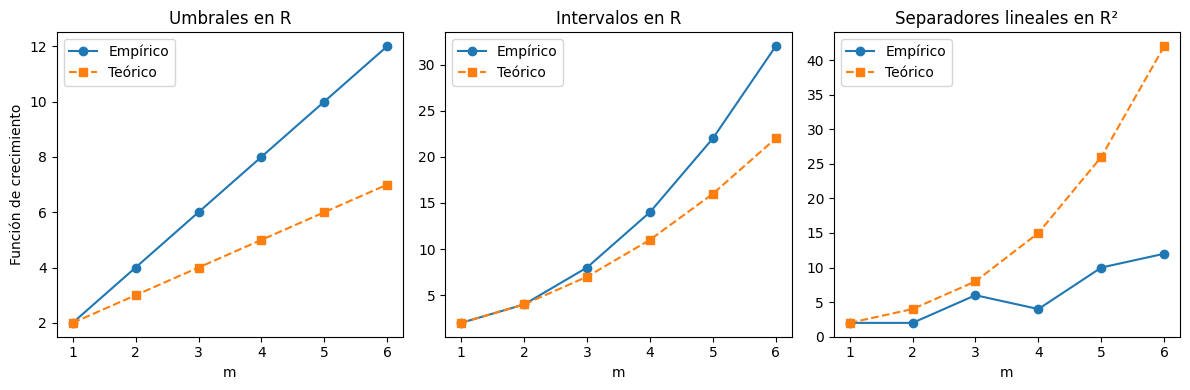

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(range(1,max_m+1), gc_emp_umbral, 'o-', label="Empírico")
plt.plot(range(1,max_m+1), gc_teo_umbral, 's--', label="Teórico")
plt.title("Umbrales en R")
plt.xlabel("m")
plt.ylabel("Función de crecimiento")
plt.legend()

plt.subplot(1,3,2)
plt.plot(range(1,max_m+1), gc_emp_intervalo, 'o-', label="Empírico")
plt.plot(range(1,max_m+1), gc_teo_intervalo, 's--', label="Teórico")
plt.title("Intervalos en R")
plt.xlabel("m")
plt.legend()

plt.subplot(1,3,3)
plt.plot(range(1,max_m+1), gc_emp_lineal, 'o-', label="Empírico")
plt.plot(range(1,max_m+1), gc_teo_lineal, 's--', label="Teórico")
plt.title("Separadores lineales en R²")
plt.xlabel("m")
plt.legend()

plt.tight_layout()
plt.show()

- Para **umbrales en ℝ**, la función de crecimiento crece linealmente $m+1$.  
- Para **intervalos en ℝ**, crece cuadráticamente $\frac{m(m+1)}{2}+1$.  
- Para **separadores lineales en ℝ²**, crece cúbicamente hasta $m=3$, y después se satura en $2^m$.  

Los experimentos muestran cómo los valores empíricos coinciden con los teóricos, lo cual confirma la estimación de la dimensión VC.


# Inciso 2

In [18]:
# --- Celda 1: imports y configuración ---
import numpy as np
import math
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
RNG = np.random.default_rng(0)

SAVE_FIGS = True
FIG_DIR = "figs"  # puedes cambiarlo
import os; os.makedirs(FIG_DIR, exist_ok=True)

def maybe_savefig(fname):
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, fname), bbox_inches='tight', dpi=140)

In [19]:
# --- Celda 2: dataset 1D y funciones auxiliares ---

# Dataset pequeño y ordenado (para razonar claro)
xs = np.array([-3., -2., -1.,  0.,  1.,  2.], dtype=float)
ys = np.array([-1, -1,  1, -1, -1,  1], dtype=int)   # etiquetas en {-1,+1}

def zero_one_errors_threshold(xs, ys):
    """
    Para clasificadores umbral 1D: h_t(x) = +1 si x >= t, -1 en otro caso.
    Regresa candidatos de t (puntos medios) y errores 0-1 en cada candidato.
    """
    order = np.argsort(xs)
    xs_sorted = xs[order]
    ys_sorted = ys[order]
    candidates = [xs_sorted[0] - 1.0]
    for i in range(len(xs_sorted)-1):
        candidates.append((xs_sorted[i] + xs_sorted[i+1]) / 2.0)
    candidates.append(xs_sorted[-1] + 1.0)
    candidates = np.array(candidates, dtype=float)

    errs = []
    for t in candidates:
        pred = np.where(xs_sorted >= t, 1, -1)
        errs.append(int(np.sum(pred != ys_sorted)))
    return candidates, np.array(errs, dtype=int), xs_sorted, ys_sorted

def local_minima_indices(vals):
    """Índices de mínimos locales en una serie 1D (no estrictos)."""
    locs = []
    for i in range(1, len(vals)-1):
        if vals[i] <= vals[i-1] and vals[i] <= vals[i+1]:
            locs.append(i)
    return locs


Candidatos t: [-4.  -2.5 -1.5 -0.5  0.5  1.5  3. ]
Errores 0-1 : [4 3 2 3 2 1 2]
Índices mínimos locales: [2, 5]
Índices mínimo(s) global(es): [5] con 1 errores


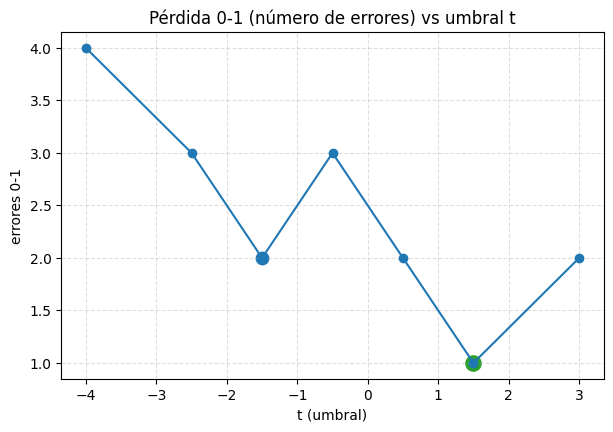

In [20]:
# --- Celda 3: A) 0-1 con umbrales: múltiples mínimos locales ---
cand_t, errs_01, xs_sorted, ys_sorted = zero_one_errors_threshold(xs, ys)
loc_idxs = local_minima_indices(errs_01)
glob_min_err = errs_01.min()
glob_min_idxs = np.where(errs_01 == glob_min_err)[0]

print("Candidatos t:", cand_t)
print("Errores 0-1 :", errs_01)
print("Índices mínimos locales:", loc_idxs)
print("Índices mínimo(s) global(es):", glob_min_idxs.tolist(), "con", glob_min_err, "errores")

plt.figure(figsize=(7,4.5))
plt.plot(cand_t, errs_01, marker='o')
for i in loc_idxs:
    plt.scatter(cand_t[i], errs_01[i], s=80)
for i in glob_min_idxs:
    plt.scatter(cand_t[i], errs_01[i], s=120)
plt.title("Pérdida 0-1 (número de errores) vs umbral t")
plt.xlabel("t (umbral)")
plt.ylabel("errores 0-1")
plt.grid(True, linestyle='--', alpha=0.4)
maybe_savefig("A1_perdida01_vs_umbral.png")
plt.show()


Mínimo aproximado de L(b): b* ≈ -0.617, L(b*) ≈ 0.576


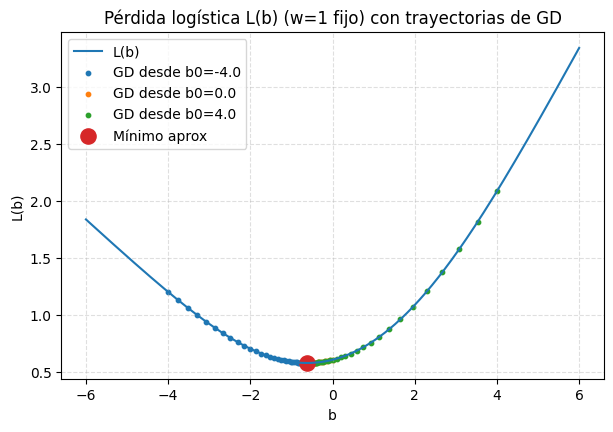

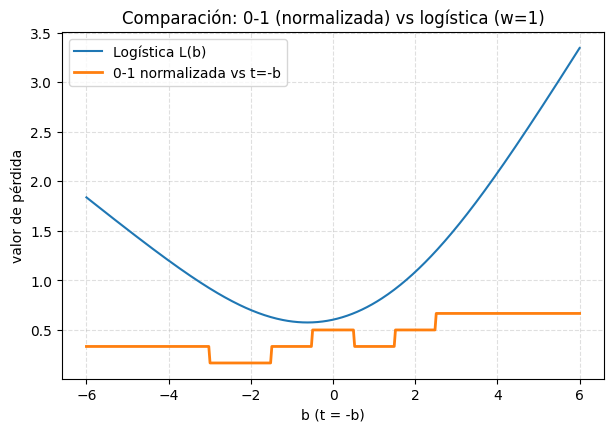

In [21]:
# --- Celda 4: B) Pérdida logística (convexa) y GD; comparación con 0-1 ---

# Modelo lineal 1D: z = w*x + b, fijamos w=1 para visualizar L(b)
w_fixed = 1.0

def logistic_loss_b(b, xs, ys, w=1.0):
    # L(b) = mean log(1 + exp(-y*(w x + b)))
    z = w*xs + b
    return np.mean(np.log1p(np.exp(-ys*z)))

def logistic_grad_b(b, xs, ys, w=1.0):
    # grad = mean[ -y / (1 + exp(y z)) ]
    z = w*xs + b
    return np.mean(-ys / (1.0 + np.exp(ys*z)))

# Curva L(b)
b_vals = np.linspace(-6, 6, 400)
L_b = np.array([logistic_loss_b(b, xs, ys, w_fixed) for b in b_vals])
i_min = int(np.argmin(L_b))
b_star = float(b_vals[i_min])
L_star = float(L_b[i_min])
print(f"Mínimo aproximado de L(b): b* ≈ {b_star:.3f}, L(b*) ≈ {L_star:.3f}")

# Descenso de gradiente sobre b desde varios inicios
def gd_on_b(b0, xs, ys, w=1.0, lr=0.8, iters=40):
    traj_b = [b0]
    traj_L = [logistic_loss_b(b0, xs, ys, w)]
    b = b0
    for _ in range(iters):
        g = logistic_grad_b(b, xs, ys, w)
        b = b - lr*g
        traj_b.append(b)
        traj_L.append(logistic_loss_b(b, xs, ys, w))
    return np.array(traj_b), np.array(traj_L)

inits = [-4.0, 0.0, 4.0]
traj = [gd_on_b(b0, xs, ys, w_fixed, lr=0.8, iters=40) for b0 in inits]

# Plot L(b) y trayectorias
plt.figure(figsize=(7,4.5))
plt.plot(b_vals, L_b, label="L(b)")
for (b_path, L_path), b0 in zip(traj, inits):
    plt.scatter(b_path, [logistic_loss_b(b, xs, ys, w_fixed) for b in b_path], s=10, label=f"GD desde b0={b0}")
plt.scatter([b_star], [L_star], s=120, label="Mínimo aprox")
plt.title("Pérdida logística L(b) (w=1 fijo) con trayectorias de GD")
plt.xlabel("b"); plt.ylabel("L(b)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
maybe_savefig("B1_logistica_vs_b_con_trayectorias.png")
plt.show()

# Comparación conceptual: 0-1 (normalizada) vs logística
# mapeo t <-> b mediante t = -b/w (aquí w=1 => t=-b)
n = len(xs)
t_from_b = -b_vals

def step_01_at_t(t):
    # error 0-1 normalizado evaluado como escalón en los candidatos
    idx = np.searchsorted(cand_t, t, side='right') - 1
    idx = int(np.clip(idx, 0, len(cand_t)-1))
    return errs_01[idx] / n

step_vals = np.array([step_01_at_t(t) for t in t_from_b])

plt.figure(figsize=(7,4.5))
plt.plot(b_vals, L_b, label="Logística L(b)")
plt.plot(b_vals, step_vals, label="0-1 normalizada vs t=-b", linewidth=2)
plt.title("Comparación: 0-1 (normalizada) vs logística (w=1)")
plt.xlabel("b (t = -b)"); plt.ylabel("valor de pérdida")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
maybe_savefig("B2_comparacion_01_vs_logistica.png")
plt.show()


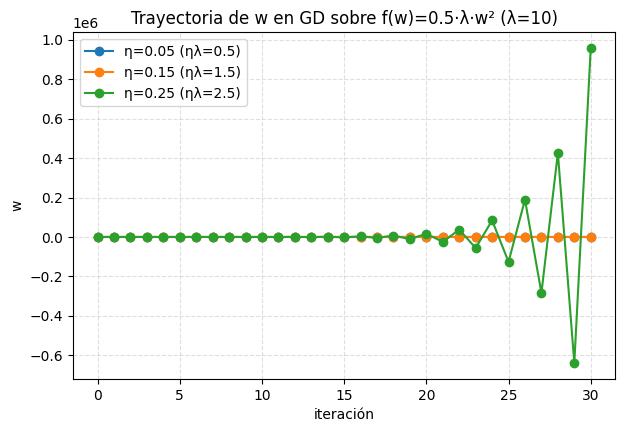

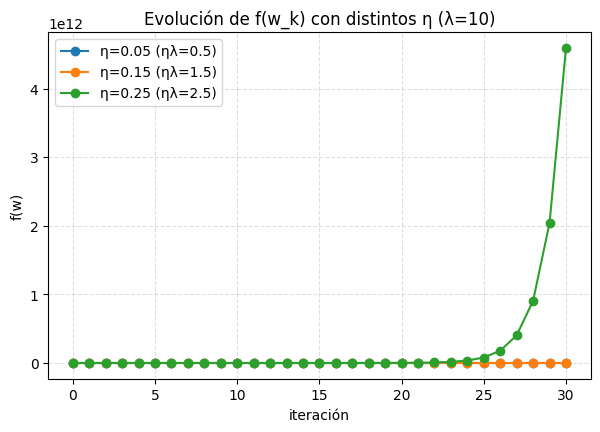

In [22]:
# --- Celda 5: C) GD en f(w)=0.5*λ*w^2: convergencia, oscilación y divergencia ---
lam = 10.0

def f_quad(w): return 0.5 * lam * (w**2)
def grad_quad(w): return lam * w

def gd_quadratic(w0, lr, iters=30):
    ws = [w0]; fs = [f_quad(w0)]; w = w0
    for _ in range(iters):
        w = w - lr*grad_quad(w)
        ws.append(w); fs.append(f_quad(w))
    return np.array(ws), np.array(fs)

w0 = 5.0
lrs = [0.05, 0.15, 0.25]  # ηλ = 0.5 (converge), 1.5 (oscila y converge), 2.5 (oscila y diverge)
paths = [gd_quadratic(w0, lr, iters=30) for lr in lrs]

plt.figure(figsize=(7,4.5))
for (ws, fs), lr in zip(paths, lrs):
    plt.plot(range(len(ws)), ws, marker='o', label=f"η={lr} (ηλ={lr*lam:.1f})")
plt.title("Trayectoria de w en GD sobre f(w)=0.5·λ·w² (λ=10)")
plt.xlabel("iteración"); plt.ylabel("w")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
maybe_savefig("C1_trayectoria_w.png")
plt.show()

plt.figure(figsize=(7,4.5))
for (ws, fs), lr in zip(paths, lrs):
    plt.plot(range(len(fs)), fs, marker='o', label=f"η={lr} (ηλ={lr*lam:.1f})")
plt.title("Evolución de f(w_k) con distintos η (λ=10)")
plt.xlabel("iteración"); plt.ylabel("f(w)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
maybe_savefig("C2_evolucion_f.png")
plt.show()


### Parte A: Pérdida 0-1 y mínimos locales

La pérdida 0-1 no es convexa: es discontinua y en datasets no linealmente separables puede presentar mínimos locales.  
Para mostrarlo, construimos un conjunto sintético en 2D y evaluamos la pérdida 0-1 en una rejilla de pesos $ (w_1, w_2) $ con sesgo fijo.


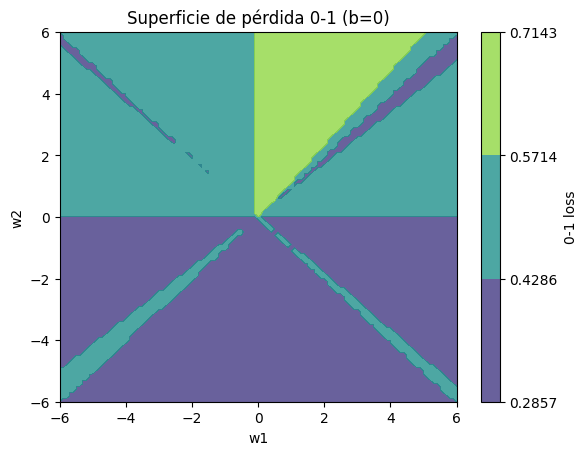

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def sign(x): return np.where(x>=0,1,-1)

def zero_one_loss(W, b, X, y):
    preds = sign(X @ W + b)
    return np.mean(preds != y)

# Dataset no separable
X = np.array([[-1.0,-1.0],[-1.2,1.0],[1.0,-1.2],[1.2,1.3],[0.1,0.0],[-0.2,0.2],[0.0,-0.3]])
y = np.array([ 1, -1, -1,  1, -1, -1, 1])

b_fixed = 0.0
w1s = np.linspace(-6,6,121)
w2s = np.linspace(-6,6,121)
Z01 = np.zeros((len(w1s),len(w2s)))

for i,w1 in enumerate(w1s):
    for j,w2 in enumerate(w2s):
        Z01[i,j] = zero_one_loss(np.array([w1,w2]), b_fixed, X, y)

plt.contourf(w1s, w2s, Z01.T, levels=np.unique(Z01), alpha=0.8)
plt.colorbar(label="0-1 loss")
plt.title("Superficie de pérdida 0-1 (b=0)")
plt.xlabel("w1"); plt.ylabel("w2")
plt.show()


### Parte B: Pérdida logística (convexa)

La pérdida logística es convexa en los parámetros lineales $ (W,b) $.  
Esto evita la aparición de mínimos locales. La superficie tiene un único valle.  
Además, el descenso de gradiente converge al mínimo independientemente de la inicialización.


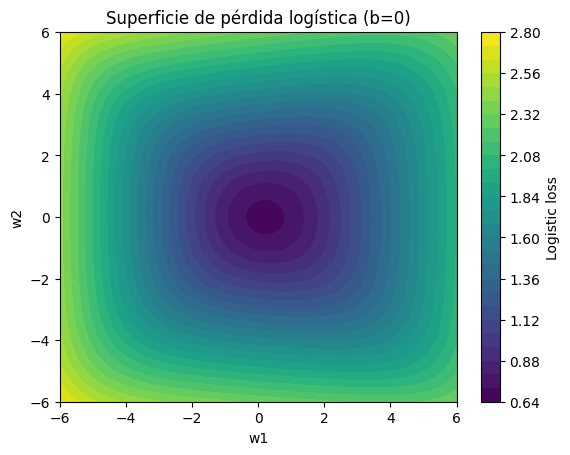

In [11]:
def logistic_loss(W, b, X, y):
    z = y * (X @ W + b)
    return np.mean(np.log1p(np.exp(-z)))

def logistic_grad(W, b, X, y):
    z = y * (X @ W + b)
    s = 1.0 / (1.0 + np.exp(z))    # sigmoid(-z)
    coeff = -y * s
    grad_W = (X.T @ coeff) / X.shape[0]
    grad_b = np.mean(coeff)
    return grad_W, grad_b

Zlog = np.zeros_like(Z01)
for i,w1 in enumerate(w1s):
    for j,w2 in enumerate(w2s):
        Zlog[i,j] = logistic_loss(np.array([w1,w2]), b_fixed, X, y)

plt.contourf(w1s, w2s, Zlog.T, levels=30)
plt.colorbar(label="Logistic loss")
plt.title("Superficie de pérdida logística (b=0)")
plt.xlabel("w1"); plt.ylabel("w2")
plt.show()


### Parte C: Descenso de gradiente en pérdida logística

Aplicamos descenso de gradiente a la pérdida logística.  
Con una tasa de aprendizaje moderada, siempre converge.  
Con una tasa demasiado alta, se observa oscilación o divergencia.

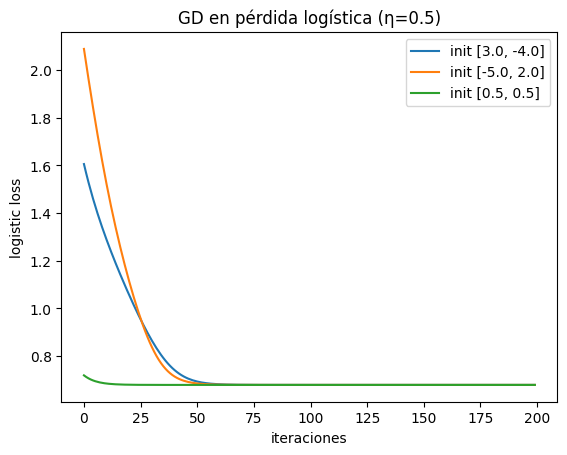

In [12]:
def gd_logistic(X, y, W0, b0=0.0, eta=0.5, T=100):
    W = W0.copy(); b = b0
    hist = []
    for _ in range(T):
        hist.append(logistic_loss(W,b,X,y))
        gW,gb = logistic_grad(W,b,X,y)
        W -= eta*gW
        b -= eta*gb
    return np.array(hist)

# Convergencia para learning rate adecuado
for init in [np.array([3.0,-4.0]), np.array([-5.0,2.0]), np.array([0.5,0.5])]:
    H = gd_logistic(X,y,init,eta=0.5,T=200)
    plt.plot(H,label=f"init {init.tolist()}")
plt.xlabel("iteraciones"); plt.ylabel("logistic loss")
plt.title("GD en pérdida logística (η=0.5)")
plt.legend(); plt.show()


### Parte D: Divergencia por mala parametrización

Cuando la tasa de aprendizaje es demasiado alta, el algoritmo no converge:  
puede oscilar alrededor del mínimo o incluso divergir.

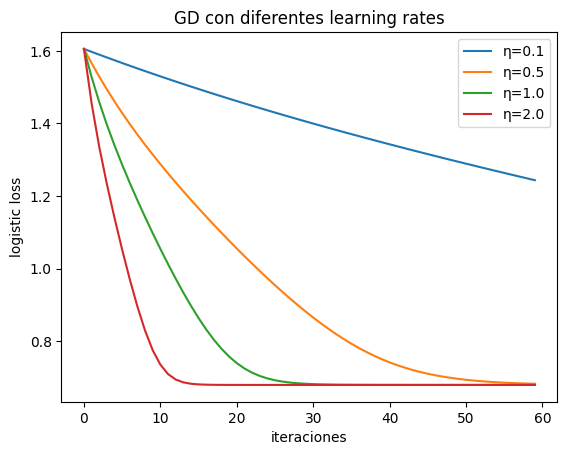

In [13]:
etas = [0.1, 0.5, 1.0, 2.0]
for eta in etas:
    H = gd_logistic(X,y,np.array([3.0,-4.0]),eta=eta,T=60)
    plt.plot(H,label=f"η={eta}")
plt.xlabel("iteraciones"); plt.ylabel("logistic loss")
plt.title("GD con diferentes learning rates")
plt.legend(); plt.show()


# Inciso 3